In [11]:
import torch
import numpy as np
import os
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

ModuleNotFoundError: No module named 'torch.nn.Transformer'

In [3]:
def printScore(file):
    directory = '/home/thire399/Documents/School/DC-MasterThesis-2023/Data/Loss_chest_xray/'
    os.chdir(directory)
    train = torch.load('train_loss' + file + '.pt').tolist()
    val = torch.load('val_loss' + file + '.pt').tolist()
    print('min train accuracy {0}\nmin val accuracy   {1}\nAfter {2} epochs'.format(
                    np.round(1-min(train),3 ),
                    np.round(1-min(val), 3),
                    val.index(min(val))))
    return None

In [14]:
def get_epochs(file, path):
    idk = str(file[5:])
    val = torch.load(f'Data/Loss_{path}/val_loss' + file[5:] + '.pt').tolist()
    return val.index(min(val))+1
get_epochs(f'model128x128FullResNet20230416-155009', 'Alzheimer_MRI')


22

# Captum

In [13]:
import captum.attr
import captum
import os
import torch
from captum.attr import visualization as viz
import matplotlib.pyplot as plt
from torchvision import models
import Models as M
import gc
import torch.nn as nn
os.chdir('/home/thire399/Documents/School/DC-MasterThesis-2023')
#del model 
gc.collect()
gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if gpu else "cpu")
#dataSet = 'chest_xray'
dataSet = 'Alzheimer_MRI'
#datasetType = '01PercentDistribution'
#datasetType = '10PercentRandom'
#datasetType = '1PercentDistribution'
datasetType = ''
#model = models.alexnet(pretrained = False)
#model.classifier[6] = nn.Linear(in_features=4096, out_features = 2, bias=True)
model = models.resnet50(pretrained = False)
model.fc = nn.Linear(in_features = 2048, out_features = 1, bias=True)
model.load_state_dict(torch.load(f'Data/Loss_{dataSet}/model128x128FullResNet20230416-155009'))
data = torch.load(f'Data/Proccesed/{dataSet}/{datasetType}trainX.pt')
y = torch.load(f'Data/Proccesed/{dataSet}/{datasetType}trainY.pt')
model.to(device)
model.eval()
DeepLift = captum.attr.DeepLift(model)
input1 = data[0].unsqueeze(0)
input2 = data[600].unsqueeze(0)
input1 = input1.repeat(1,3,1,1).float()
input2 = input2.repeat(1,3,1,1).float()
print(input1.shape)

attrDeepLift1 = DeepLift.attribute(input1.to(device), target = 0)
attrDeepLift2 = DeepLift.attribute(input2.to(device), target = 1)

vis_types = ["heat_map", "original_image"]
vis_signs = ["absolute_value", "absolute_value"]

fig, ax = plt.subplots(1, 2, figsize = ( 10,10))
fig1, ax1 = viz.visualize_image_attr(attrDeepLift1[0][1].squeeze().unsqueeze(2).cpu().detach().numpy()+1e-10,
                                        plt_fig_axis = (fig, ax[0]),
                                        cmap = 'twilight',
                                        show_colorbar = True,
                                        title = str(y[0].item()),
                                        use_pyplot = False)
fig2, ax2 = viz.visualize_image_attr(attrDeepLift2[0][1].squeeze().unsqueeze(2).cpu().detach().numpy()+1e-10,
                                        plt_fig_axis = (fig, ax[1]),
                                        cmap = 'twilight',
                                        show_colorbar = True,
                                        title = str(y[1].item()),
                                        use_pyplot = False)
plt.tight_layout()
plt.show()

torch.Size([1, 3, 128, 128])


RuntimeError: A Module ReLU(inplace=True) was detected that does not contain some of the input/output attributes that are required for DeepLift computations. This can occur, for example, if your module is being used more than once in the network.Please, ensure that module is being used only once in the network.

# Size tool 

label 0
torch.Size([1, 128, 128])
torch.Size([4032, 1, 128, 128])
Distribution torch.Size([4032]) tensor(2016)


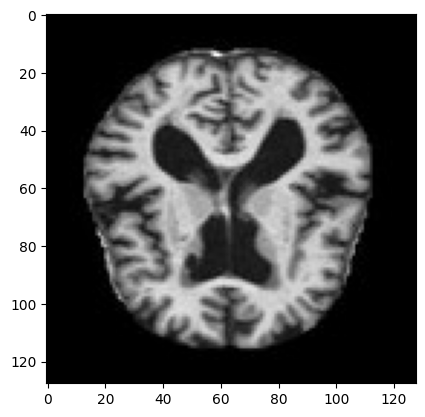

In [2]:
import torch 
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import os
index = 1
dataset = 'Alzheimer_MRI'
#dataset = 'chest_xray'
#datasetType = '01PercentDistribution'
#datasetType = '10PercentRandom'
#datasetType = '10PercentDistribution'
datasetType = ''
directory = '/home/thire399/Documents/School/DC-MasterThesis-2023/Data'
os.chdir(directory)
data = torch.load(f'Proccesed/{dataset}/'+ datasetType +'trainX.pt')
y = torch.load(f'Proccesed/{dataset}/'+ datasetType +'trainY.pt')
print(f'label {y[index]}')
print(data[index].shape)
print(data.shape)
#print(data[index])
plt.imshow(data[index][0], cmap = 'gray')
print('Distribution', y.shape, sum(y))
#print(torch.max(data[0]), torch.min(data[0]))
plt.show()
#from torchvision import models
#import torch.nn as nn
#import torch
#model = models.resnet50(pretrained = False)
#
#model.fc = nn.Linear(in_features = 2048, out_features = 1, bias=True)
#model.fc.add_module('sigmoid', nn.Sigmoid())
#data = data.repeat(1,3,1,1)
#Set = torch.utils.data.TensorDataset(data, y)
#Loader = torch.utils.data.DataLoader(Set,
#                                        batch_size = 10,
#                                        shuffle = True,
#                                        num_workers = 0)
#for i, (dd, yy) in enumerate(Loader):
#    out = model(data.type(torch.float32))
#    out = nn.Sigmoid()(out)
#    break
##out = out.clamp(min = 0)
#
#for i in range(10):
#    print(out[i], yy[i].item())



# Accuracy

In [10]:
import Loop
import importlib
importlib.reload(Loop)
import torch.nn as nn
from torchvision import models
import numpy as np
import Models as M
import gc
import os
import torch
os.chdir('/home/thire399/Documents/School/DC-MasterThesis-2023')
#del model 
gc.collect()
#model = models.alexnet(pretrained = False)
#model.classifier[6] = nn.Linear(in_features=4096, out_features = 1, bias=True)

model = models.resnet50(pretrained = False)
model.fc = nn.Linear(in_features=2048, out_features = 1, bias=True)
#model = M.UNet(enc_chs = (3, 64, 128, 256, 512, 1024)
#               , dec_chs = (1024, 512, 256, 128, 64)
#               , num_class = 1
#               , df = 16384) # binary classification = 1.
batch_size   = 12
#Data parameters
dataSet      = 'Alzheimer_MRI'  
#dataSet      = 'chest_xray'
lst = ['model128x128FullResNet20230416-153451'
        ,'model128x128FullResNet20230416-154252'
        ,'model128x128FullResNet20230416-155009']

def averageAcc(lst):
    F1List = []
    nepochs = []
    for i in lst:
        tempMOdel = f"Data/Loss_{dataSet}/{i}"

        datatype     = ''
        os.makedirs(f'Data/Loss_{dataSet}/test', exist_ok = True)
        costumLabel  = '64x64Full'

        xVal = torch.load('Data/Proccesed/'+ dataSet + '/' + datatype +'ValX.pt')
        yVal = torch.load('Data/Proccesed/'+ dataSet + '/' + datatype +'ValY.pt')

        xVal = xVal.repeat(1, 3, 1, 1)     # only for pretrained model

        tempval_Set = torch.utils.data.TensorDataset(xVal, yVal)
        tempval_Loader = torch.utils.data.DataLoader(tempval_Set,
                                                batch_size = batch_size,
                                                shuffle = True,
                                                num_workers = 0)
        print('TempVal')
        fscore, pred, bestT = Loop.eval_model(model = model
                        , dataset = dataSet
                        , dev = False
                        , val_Loader = tempval_Loader
                        , model_filePath = tempMOdel
                        , size = costumLabel
                        , isPrint = False)
        F1List.append(fscore)
        nepochs.append(get_epochs(i, dataSet))
    print(f'Average f1-score: {round(np.mean(np.asarray(F1List)), 3)} for {len(F1List)} runs\n',
          f'Number of epoch on average {round(np.mean(np.asarray(nepochs)), 0)}')
    print(f'STD for f1-score: {np.std(np.asarray(F1List))} for {len(F1List)} runs\n', 
          f'STD for number of epochs {np.std(np.asarray(nepochs))}')
    #print('Accuracy on temp ValidationSet: {0}     --> (sum(Prediction = Target))/n_sampels'.format(np.sum([p == t])/t.shape[0]))
    if dataSet != 'Alzheimer_MRI':
        xVal = torch.load('Data/Proccesed/'+ dataSet + '/ValX.pt')
        yVal = torch.load('Data/Proccesed/'+ dataSet + '/ValY.pt')

        xVal = xVal.repeat(1, 3, 1, 1)     # only for pretrained model

        val_Set = torch.utils.data.TensorDataset(xVal, yVal)
        val_Loader = torch.utils.data.DataLoader(val_Set,
                                                batch_size = batch_size,
                                                shuffle = True,
                                                num_workers = 0)

        print('Val')
        fscore, pred, _= Loop.eval_model(model = model
                        , dataset = dataSet
                        , dev = False
                        , val_Loader = val_Loader
                        #, model_filePath = tempMOdel
                        , size = costumLabel
                        , threshold = bestT
                        )
    return None
print('Full')
lst = ['model128x128FullResNet20230416-153451'
        ,'model128x128FullResNet20230416-154252'
        ,'model128x128FullResNet20230416-155009']
averageAcc(lst)

print('\n\n 10PercentRandom')
lst = ['model128x128-10PercentRandomResNet20230416-155642'
        ,'model128x128-10PercentRandomResNet20230416-155925'
        ,'model128x128-10PercentRandomResNet20230416-160157']
averageAcc(lst)

print('\n\n 1PercentRandom')
lst = ['model128x128-1PercentRandomResNet20230416-160813'
        ,'model128x128-1PercentRandomResNet20230416-162119'
        ,'model128x128-1PercentRandomResNet20230416-164844']
averageAcc(lst)

print('\n\n 01PercentRandom')
lst = ['model128x128-01PercentRandomResNet20230416-165242'
        ,'model128x128-01PercentRandomResNet20230416-165341'
        ,'model128x128-01PercentRandomResNet20230416-165449']
averageAcc(lst)


print('\n\n 10PercentDistribution')
lst = ['model128x128-10PercentDistributionResNet20230416-165941'
        ,'model128x128-10PercentRandomResNet20230416-155642'
        ,'model128x128-10PercentRandomResNet20230416-155925']
averageAcc(lst)

print('\n\n 1PercentDistribution')
lst = ['model128x128-1PercentDistributionResNet20230416-170123'
        ,'model128x128-1PercentDistributionResNet20230416-170302'
        ,'model128x128-1PercentDistributionResNet20230416-170451']
averageAcc(lst)

print('\n\n 01PercentDistribution')
lst = ['model128x128-01PercentDistributionResNet20230416-170635'
        ,'model128x128-01PercentDistributionResNet20230416-170755'
        ,'model128x128-01PercentDistributionResNet20230416-170823']
averageAcc(lst)
print('\n\n 30PercentDistribution')
lst = ['model128x128-30PercentDistributionResNet20230416-170929'
        ,'model128x128-30PercentDistributionResNet20230416-171116'
        ,'model128x128-30PercentDistributionResNet20230416-171313']
averageAcc(lst)



Full
TempVal
Using:  cuda:0
Model specified.
Using trained model: "Data/Loss_Alzheimer_MRI/model128x128FullResNet20230416-153451"
Data/Loss_Alzheimer_MRI/model128x128FullResNet20230416-153451
Best Threshold=0.151809, F-Score=0.976
Precision: 0.9617977528089887
Recall: 0.9907407407407407
TempVal
Using:  cuda:0
Model specified.
Using trained model: "Data/Loss_Alzheimer_MRI/model128x128FullResNet20230416-154252"
Data/Loss_Alzheimer_MRI/model128x128FullResNet20230416-154252
Best Threshold=0.685816, F-Score=0.964
Precision: 0.9556313993174061
Recall: 0.9722222222222222
TempVal
Using:  cuda:0
Model specified.
Using trained model: "Data/Loss_Alzheimer_MRI/model128x128FullResNet20230416-155009"
Data/Loss_Alzheimer_MRI/model128x128FullResNet20230416-155009
Best Threshold=0.539661, F-Score=0.946
Precision: 0.9508771929824561
Recall: 0.9409722222222222
Average f1-score: 0.962 for 3 runs
 Number of epoch on average 31.0
STD for f1-score: 0.01238568097626281 for 3 runs
 STD for number of epochs 6.4

In [21]:
model = models.densenet169(pretrained = False)
model.classifier = nn.Linear(in_features=1664, out_features = 1, bias=True)
print('\n\n 30PercentDistribution')
lst = [  'model128x128-30PercentDistributionDenseNet20230416-223548'
        ,'model128x128-30PercentDistributionDenseNet20230416-223806'
        ,'model128x128-30PercentDistributionDenseNet20230416-224028']
averageAcc(lst)



 30PercentDistribution
TempVal
Using:  cuda:0
Model specified.
Using trained model: "Data/Loss_Alzheimer_MRI/model128x128-30PercentDistributionDenseNet20230416-223548"
Data/Loss_Alzheimer_MRI/model128x128-30PercentDistributionDenseNet20230416-223548
Best Threshold=0.441130, F-Score=0.744
Precision: 0.6496980155306299
Recall: 0.8715277777777778
TempVal
Using:  cuda:0
Model specified.
Using trained model: "Data/Loss_Alzheimer_MRI/model128x128-30PercentDistributionDenseNet20230416-223806"
Data/Loss_Alzheimer_MRI/model128x128-30PercentDistributionDenseNet20230416-223806
Best Threshold=0.404800, F-Score=0.729
Precision: 0.6306001690617076
Recall: 0.8634259259259259
TempVal
Using:  cuda:0
Model specified.
Using trained model: "Data/Loss_Alzheimer_MRI/model128x128-30PercentDistributionDenseNet20230416-224028"
Data/Loss_Alzheimer_MRI/model128x128-30PercentDistributionDenseNet20230416-224028
Best Threshold=0.314046, F-Score=0.779
Precision: 0.6948228882833788
Recall: 0.8854166666666666
Averag

In [29]:
from carbontracker import parser
dataSet      = 'chest_xray'
directory = '/home/thire399/Documents/School/DC-MasterThesis-2023'
os.chdir(directory)


parser.print_aggregate(log_dir= 'Data/Loss_' + dataSet + '/CarbonLogs')
logs = parser.parse_all_logs(log_dir = 'Data/Loss_' + dataSet + '/CarbonLogs')
first_log = logs[5]
print(f"Output file name: {first_log['output_filename']}")
print(f"Standard file name: {first_log['standard_filename']}")
print(f"Stopped early: {first_log['early_stop']}")
print(f"Measured consumption: {first_log['actual']}")
print(f"Predicted consumption: {first_log['pred']}")
print(f"Measured GPU devices: {first_log['components']['gpu']['devices']}")

The training of models in this work is estimated to use 0.054 kWh of electricity contributing to 0.004 kg of CO2eq. This is equivalent to 0.039 km travelled by car. Measured by carbontracker (https://github.com/lfwa/carbontracker).
Output file name: Data/Loss_chest_xray/CarbonLogs/64x64RandomUNet_17135_2023-04-03T191445Z_carbontracker_output.log
Standard file name: Data/Loss_chest_xray/CarbonLogs/64x64RandomUNet_17135_2023-04-03T191445Z_carbontracker.log
Stopped early: True
Measured consumption: {'epochs': 46, 'duration (s)': 149.0, 'energy (kWh)': 0.00382, 'co2eq (g)': 0.343831, 'equivalents': {'km travelled by car': 0.003198}}
Predicted consumption: {'epochs': 400, 'duration (s)': 1649.0, 'energy (kWh)': 0.038144, 'co2eq (g)': 4.144998, 'equivalents': {'km travelled by car': 0.038558}}
Measured GPU devices: ['NVIDIA GeForce RTX 3070 Laptop GPU']


Simple remake of the distribution coreset selection dataset into a temp validation set and train set.

In [ ]:
import os
import torch
from sklearn.model_selection import train_test_split

dataSet = 'chest_xray'
directory = '/home/thire399/Documents/School/DC-MasterThesis-2023'
os.chdir(directory)
x = torch.load('Data/Proccesed/chest_xray/DistributiontrainXBeforeSplit.pt')
y = torch.load('Data/Proccesed/chest_xray/DistributiontrainYBeforeSplit.pt')
trainX, tempValX, trainY, tempValY = train_test_split(x, y, test_size = 0.2, random_state= 1)
torch.save(trainX, f = 'Data/Proccesed/chest_xray/DistributiontrainX.pt')
torch.save(trainY, f = 'Data/Proccesed/chest_xray/DistributiontrainY.pt')
torch.save(tempValX, f = 'Data/Proccesed/chest_xray/DistributiontempValX.pt')
torch.save(tempValY, f = 'Data/Proccesed/chest_xray/DistributiontempValY.pt')
